# Big Data Project
Buongiorno a tutti

In [2]:
# inizializziamo la SparkSession e importiamo le librerie
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession \
    .builder \
    .appName("Spark ML example on Credit Card data") \
    .getOrCreate()

21/10/09 13:11:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Lettura del file da hdfs con spark e conteggio delle colonne con valori nulli/NaN

In [3]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

nullValues = dataSet.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataSet.columns])
nullValues.show()

21/10/09 13:11:40 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Convertiamo in Pandas per una gestione più semplice per poter fare i grafici

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

Grafico X: Amount --> Y: Class

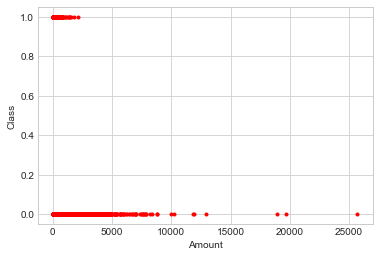

In [5]:
X = df['Amount']
Y = df['Class']

plt.style.use('seaborn-whitegrid')
plt.xlabel("Amount")
plt.ylabel("Class")
plt.scatter(X, Y, marker = ".", color = 'red')
plt.show()

È possibile dedurre che il dataset è sbilanciato e che le transazioni con class = 1 (frodi) hanno un valore di Amount relativamente basso (< 5000).

Grafico: X: Time -- Y:Amount (Rosso frode - Blu non frode)

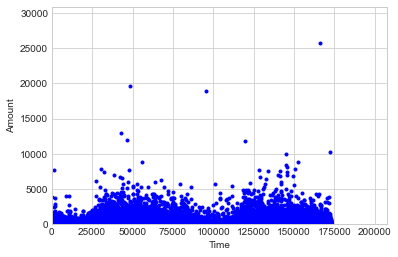

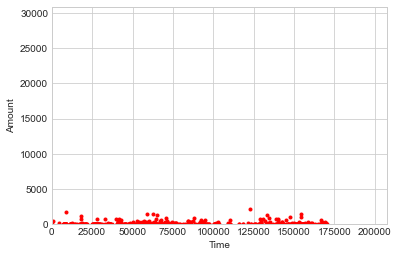

In [6]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.show()

#Grafico frode
X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.xlim(0, xlim)
plt.ylim(0, ylim)
plt.scatter(X, Y, marker = ".", color = "red")
plt.show()

Secondo me (Davide) è possibile fare discorsi sulla colonna Time, eliminabile a prescindere

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13        True
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23        True
V24       False
V25       False
V26        True
V27       False
V28       False
Amount    False
Class     False
Name: Class, dtype: bool


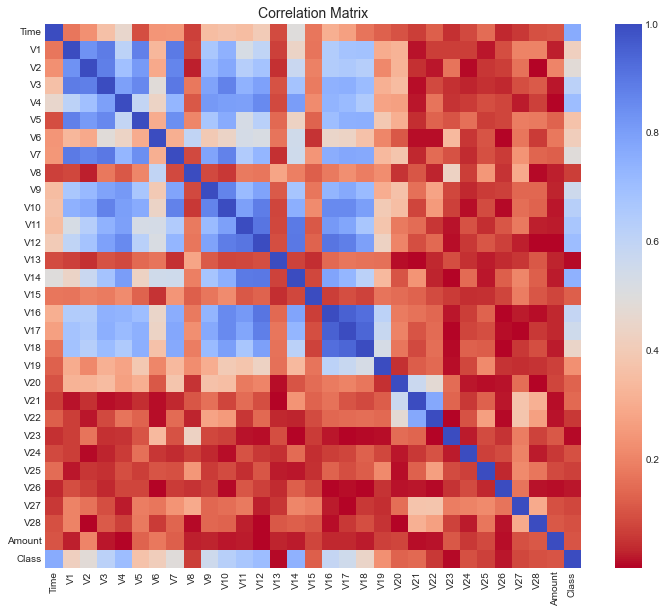

In [53]:
import seaborn as sns

# shuffle before creating subsamples

df_fraud = df.loc[df.Class == 1]
df_non_fraud = df.loc[df.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

Calcolo matrice di covarianza per capire quali attributi è possibile eliminare

In [17]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

from sklearn import preprocessing

minMaxScaler = preprocessing.MinMaxScaler()
scaledTime = minMaxScaler.fit_transform(dfFinal[['Time']])
scaledAmount = minMaxScaler.fit_transform(dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

dfFinal = dfFinal.drop(['Time', 'Amount'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

MLPC = MLPClassifier(hidden_layer_sizes=(200,), max_iter=10000)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test,y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

0.21768707482993196


In [73]:
soglia = 0.05
#print(corr["Class"] < soglia)
#droppiamo V13 e V23 perchè minori della soglia
dfFinal = df.drop(["V13", "V23"], axis = 1)

from sklearn import preprocessing

standardScaler = preprocessing.StandardScaler()
scaledTime = standardScaler.fit_transform(X = dfFinal[['Time']])
scaledAmount = standardScaler.fit_transform(X = dfFinal[['Amount']])

dfFinal['ScaledTime'] = scaledTime
dfFinal['ScaledAmount'] = scaledAmount

#ELIMINO V26 PERCHè NELLA MATRICE DI CORRELAZIONE DEL PASSO SUCCESSIVO, V26 è MINORE DI 0.05
dfFinal = dfFinal.drop(['Time', 'Amount', 'V26', 'ScaledTime'], axis = 1)

X = dfFinal.iloc[:, dfFinal.columns != 'Class']
y = dfFinal.iloc[:, dfFinal.columns == 'Class']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3, random_state = 50)

from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

#hidden_layer_sizes=(200,)
MLPC = MLPClassifier(hidden_layer_sizes=(250,), max_iter=10000, activation="tanh", verbose=True)
MLPC.fit(X_train, y_train.values.ravel())
y_pred = MLPC.predict(X_test)
# Obtenemos valores de recall
recall_acc = recall_score(y_test, y_pred)
print(recall_acc)
print(MLPC.score(X_test, y_test))

Iteration 1, loss = 0.03267204
Iteration 2, loss = 0.00310861
Iteration 3, loss = 0.00286551
Iteration 4, loss = 0.00273150
Iteration 5, loss = 0.00266197
Iteration 6, loss = 0.00252111
Iteration 7, loss = 0.00253917
Iteration 8, loss = 0.00243780
Iteration 9, loss = 0.00243894
Iteration 10, loss = 0.00232684
Iteration 11, loss = 0.00219814
Iteration 12, loss = 0.00223027
Iteration 13, loss = 0.00215770
Iteration 14, loss = 0.00207053
Iteration 15, loss = 0.00201782
Iteration 16, loss = 0.00196753
Iteration 17, loss = 0.00189801
Iteration 18, loss = 0.00188568
Iteration 19, loss = 0.00182609
Iteration 20, loss = 0.00181075
Iteration 21, loss = 0.00173497
Iteration 22, loss = 0.00164904
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
0.7959183673469388
0.9994850368081645


Divisione del dataset in training set e validation set

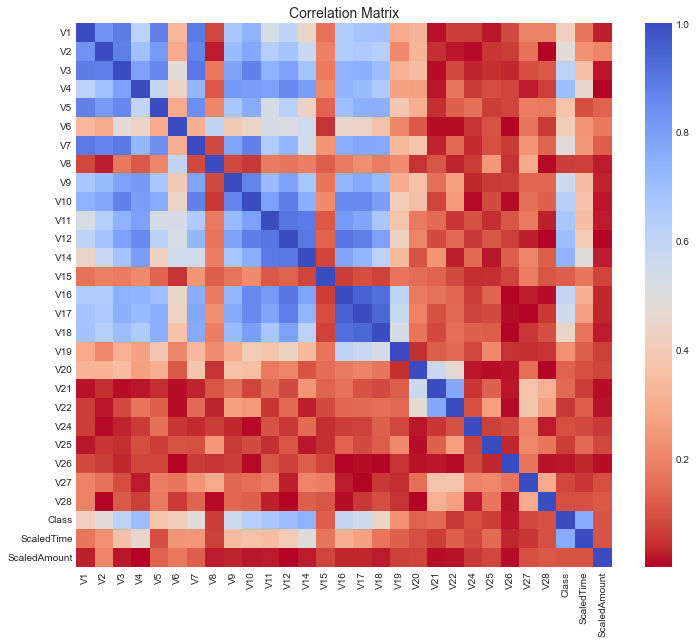

V1              False
V2              False
V3              False
V4              False
V5              False
V6              False
V7              False
V8              False
V9              False
V10             False
V11             False
V12             False
V14             False
V15             False
V16             False
V17             False
V18             False
V19             False
V20             False
V21             False
V22             False
V24             False
V25             False
V26              True
V27             False
V28             False
Class           False
ScaledTime      False
ScaledAmount    False
Name: Class, dtype: bool


In [55]:
# shuffle before creating subsamples

df_fraud = dfFinal.loc[dfFinal.Class == 1]
df_non_fraud = dfFinal.loc[dfFinal.Class == 0][1000:1492]

dfFifty = pd.concat([df_fraud, df_non_fraud])

plt.figure(figsize=(12, 10))
corr = dfFifty.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

print(corr["Class"] <= 0.05)

Creazione del modello di predizione

In [51]:
print(corr["Class"] <= 0.1)

V1              False
V2              False
V3              False
V4              False
V5              False
V6              False
V7              False
V8               True
V9              False
V10             False
V11             False
V12             False
V14             False
V15             False
V16             False
V17             False
V18             False
V19             False
V20             False
V21             False
V22              True
V24              True
V25              True
V26              True
V27              True
V28              True
Class           False
ScaledTime      False
ScaledAmount    False
Name: Class, dtype: bool


Valutazione dell'errore del modello ottenuto al passo precedente